In [1]:
import sys
sys.path.append('/Users/clancy/repos/meg')
#import mpld3

#%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
#from mpl_toolkits.mplot3d import axes3d
from numpy.linalg import norm
from dipole_class import DipoleLocalizer
from data_generator_class import DataGenerator
import numpy.random as RA
import numpy.linalg as LA

# set up configuration file. 
# Note: config files describe mesh to be used, for instance, a one layer spherical mesh, cartesian over a volumne etc,
config_file = "configs/beamformer_test_spherical_mesh.yaml"
#config_file = "configs/beamformer_test.yaml"

# initialize dipole with config file
dip_loc = DipoleLocalizer(config_file)  

# reset number of sensors
settings = dip_loc.settings
settings['sensors']['num_sensors'] = 20
del dip_loc

# reinitialize dipole localizers with a different number of sensors
dip_loc = DipoleLocalizer(settings)
nsensors = dip_loc.sensors.shape[0]

# select number of sources to use
ndips = 3

# fix number of time steps
ntimes = 10000
np.random.seed(1)

# take mesh
mymesh = dip_loc.mesh

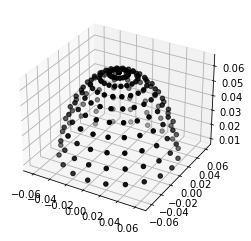

In [2]:
# plot mesh points we are using (we will want to expand this to a general volume, not a shell)
fig = plt.figure();
ax = fig.add_subplot(1,1,1, projection='3d');
scat = ax.scatter(mymesh[:,0], mymesh[:,1], mymesh[:,2], label='True dipole', color='k');


In [3]:
# we are forming matrix with dipole locations. Each row of the matrix is the location of one of the source dipoles
Ps = mymesh   #[pidx[0:nsensors],:]
Qs = np.zeros(Ps.shape)
Llist = list()

# for each mesh point, draw a dipole orientated in the tangent plane
for i, p in enumerate(mymesh):
    q = RA.randn(3)                 # pull a random vector
    ptemp = p/norm(p)               # get unit vector for mesh point
    q = q - ptemp*np.dot(ptemp,q)   # project out the radial component of q
    q = q/norm(q)                   # normalize q
    Qs[i,:] = q                     # store q for corresponding mesh point
    Llist.append(1.e10*dip_loc.lead_field_obj.get_lead_field(p)@q)

# pick several locations to use for source dipoles
pidx = RA.permutation(mymesh.shape[0])

# take the source dipole locations
Psource = Ps[pidx[0:ndips], :]
Qsource = Qs[pidx[0:ndips],:]


Y = np.zeros((nsensors,ntimes))     # initialize sensor readings
A = np.zeros((nsensors,ndips))      # initialize mixing matrix
S = RA.randn(ntimes,ndips)          # initialize source signal to be random (will need to change this)
Q, R = np.linalg.qr(S, mode='reduced')          # orthogonalize the source signal to be random
S = Q.T                                         # transpose for the right dimensions
freqs = np.random.uniform(0, 1000, (ndips,))    # randomly draw frequencies to use (not used though)
for i, (p,q) in enumerate(zip(Psource, Qsource)):
    L = 1e10*dip_loc.lead_field_obj.get_lead_field(p)   # generate lead field matrix for a current source dipole
    A[:,i] = L@q                                        # store corresponding column for lead field in mixing matrix

    # generate matrix of sensor readings: outer product of column of mixing matrix and source time course
    Y += np.outer(L@q, S[i,:])
    #Y += np.dot((L@q).reshape(L.shape[0],1), S[i,:].reshape(1,S.shape[1]))   


C = Y@Y.T                                   # form covariance matrix
noise = RA.normal(0,0.1*np.std(Y), Y.shape) # construct noise matrix
C_noise = noise@noise.T                     # form noise covariance matrix
Cinv = np.linalg.inv(C+C_noise)             # calculate inverse covariance matrix

In [4]:
mus = np.zeros(mymesh.shape[0])             # initialize beam former power
W = np.zeros((mymesh.shape[0],nsensors))    # initialize unmixing matrix

# step through each dipole location and determine beamformer power
for i, (p, l) in enumerate(zip(mymesh, Llist)):
    denom = l.T@(Cinv@l)                    # denominator for beamformer power
    W[i,:] = (Cinv@l)/denom                 # 
    mus[i] = 1/denom
idx = np.argsort(mus)
idx = idx[::-1]
mus = mus[idx]
new_mesh = mymesh[idx,:]

/var/folders/93/rs3bwg315nl_l8vgz1bsklv40000gn/T/ipykernel_3081/3527337883.py:3: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot('111', projection='3d')


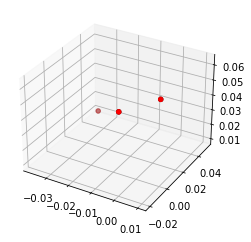

In [5]:
fig = plt.figure()

ax = fig.add_subplot('111', projection='3d')
scat = ax.scatter(Psource[:,0], Psource[:,1], Psource[:,2], label='True dipole', color='k')

Psol = Ps[idx[0:ndips],:]
scat = ax.scatter(Psol[:,0], Psol[:,1], Psol[:,2], label='True dipole', color='r')

#sens = dip_loc.sensors 
#scat = ax.scatter(sens[:,0], sens[:,1], sens[:,2], label='True dipole', color='g')

In [6]:
norm(Psol-Psource,axis=1)
import copy
temp = copy.copy(Psource)
for p in Psol:
    diffnorms = norm(temp-np.tile(p, (temp.shape[0],1)), axis=1)
    #print(diffnorms)
    idx = np.argmin(diffnorms)
    #print(idx)
    #if isinstance(diffnorms, np.ndarray):
    print("Location error", diffnorms[idx])
    #else:
    #    print("Location error", diffnorms)
    temp = np.delete(temp, idx, axis=0)
    
    

Location error 0.0
Location error 0.0
Location error 0.0


In [7]:
rt = 4
print(np.round(Psol,rt))
print(np.round(Psource,rt))

[[-0.037   0.0509  0.01  ]
 [ 0.01    0.      0.0629]
 [-0.     -0.0197  0.0606]]
[[-0.037   0.0509  0.01  ]
 [-0.     -0.0197  0.0606]
 [ 0.01    0.      0.0629]]


In [8]:
#fig = plt.figure()
#mymesh2 = dip_loc.mesh[idx,:]
#ax = fig.add_subplot('111', projection='3d')
#scat = ax.scatter(mymesh2[:,0], mymesh2[:,1], mymesh2[:,2], s=10*mus, label='True dipole', color='k')


In [9]:
XX = RA.randn(10,3)
XX = np.delete(XX, 2, axis = 0)

In [10]:
XX.shape

(9, 3)

In [11]:
#def fixed_oriented_beamformer(X, Ps, Qs, weighting=None, localizer=None, C_noise=None):
def fixed_oriented_beamformer(X, lead_fields, Ps, weighting=None, localizer=None, C_noise=None):
    # we only consider the noise case here (no need to account for non-invertible covariance)
    n_meshpoints = Ps.shape[0]
    Xmean = np.mean(X, axis=1)  # get mean for each row
    X = (X.T - Xmean).T         # center rows of data
    C = X@X.T                   # form variance matrix
    Cinv = LA.inv(C)            # take inverse covariance (might not want to form inverse)

    # create lambda function used to search for regions of maximum beamformer power
    tau = get_localizer_function(localizer, C_noise)
    mu = np.zeros(n_meshpoints)
    # for potential source location, compute beamformer power at that location  

    # maybe here, loop through Ps and Qs to see if there is already a leadfield calculated

    #for i, (p, q) in enumerate(zip(Ps,Qs)):
    for i, l in enumerate(lead_fields):
        Cinv_l = Cinv@l
        mu[i] = tau(l)
        W[i,:] = Cinv_l/mu[i]

    # find indices of largest power    
    idx = np.argsort(mu)[::-1]
    max_idx = idx[0]

    # from here, I would like to step through all of the data and only keep points that are local maxima
    # unfortunately, this will require tracking adjacent nodes which I'm not sure how to do

    wopt = W[max_idx,:]
    S_ = wopt@X         # this should extract the sources time course

    p_opt = Ps[max_idx,:]
    

    return p_opt

    





def get_localizer_function(localizer, C_noise):
    F = None
    # array gain
    if localizer == "ag":
        F = np.eye(C.shape[0])
        G = Cinv = LA.inv(C)
    # activity index
    if localizer == "ai":
        if C_noise == None:
            print("Must specifiy noise covaraince matrix if using 'ai' or activity index")
        F = LA.inv(C_noise)
        G = Cinv
    # psuedo-Z
    if localizer == "pz":
        if C_noise == None:
            print("Must specifiy noise covaraince matrix if using 'pz' or psuedo-Z")
        F = Cinv
        G = Cinv@C_noise@Cinv
    
    # if no special localizer is caught, use standard function
    if F is None:
        tau = lambda v: 1/(v.T@(Cinv@v))
        if localizer is not None:
            print("Choose valid localizer, 'ai' (activity index), 'pz' (psuedo-Z), or 'ag' (array gain)")
    else:
        tau = lambda v: (v.T@(F@v))/(v.T@(G@v))


SyntaxError: invalid syntax (2115588945.py, line 45)